# Table of content
- Load Data
- MA-plot before LFC shrinkage
- MA-plot after LFC shrinkage
- Viewing individual gene counts between two conditions
- Viewing pairwise sample clustering
    - distance metric
    - similarity metric such as a Peason correlation
    - instead of boiling all the gene count data for each sample down to a distance metric you can get a similar sense of the pattern by just visualizing all the genes at once

# Load data

In [ ]:
cd $RNA_HOME/de/deseq2
R
setwd("~/workspace/rnaseq/de/deseq2")

# load libs
library(DESeq2)
library(data.table)
library(pheatmap)

# Load in the DESeqDataSet object ($RNA_HOME/de/deseq2/dds.rds)
dds = readRDS("dds.rds")

# Load in the results object before shrinkage ($RNA_HOME/de/deseq2/res.rds)
res = readRDS("res.rds")

# Load in the results object after shrinkage ($RNA_HOME/de/deseq2/resLFC.rds)
resLFC = readRDS("resLFC.rds")

# Load in the final results file with all sorted DE results (http://genomedata.org/cri-workshop/deseq2/DE_all_genes_DESeq2.tsv)
deGeneResultSorted = fread("DE_all_genes_DESeq2.tsv") 

# MA-plot before LFC shrinkage
MA-plots were originally used to evaluate microarray expression data where M is the log ratio and A is the mean intensity for a gene (both based on scanned intensity measurements from the microarray).

These types of plots are still usefull in RNAseq DE experiments with two conditions, as they can immediately give us information on the number of signficantly differentially expressed genes, the ratio of up vs down regulated genes, and any outliers. 

**To interpret these plots it is important to keep a couple of things in mind.**
- The Y axis (M) is the log2 fold change between the two conditions tested, a higher fold-change indicates greater difference between condition A and condition B.
- The X axis (A) is a measure of read alignment to a gene, so as you go higher on on the X axis you are looking at regions which have higher totals of aligned reads, in other words the gene is “more” expressed overall (with the caveat that gene length is not being taken into account by raw read counts here).

| Axis  | What it shows                                    | Data column      |
| ----- | ------------------------------------------------ | ---------------- |
| **X** | Mean expression across all samples (log10 scale) | `baseMean`       |
| **Y** | Log2 fold change between conditions              | `log2FoldChange` |


**Using the built-in plotMA function from DESeq2 we also see that the genes are color coded by a significance threshold (grey vs blue). Genes with higher expression values and higher fold-changes (blue) are more often significant as one would expect.**

**What we'll see in the plot:**
- Genes on the left have low expression (low baseMean)
- Genes on the right have high expression
- Triangles at the top and bottom (open) = genes with log2 fold changes greater than 2 or less than -2, clipped at the ylim=c(-2, 2) range
- Blue points = significantly differentially expressed genes (padj < 0.1 by default)
- Grey points = not significant

In [ ]:
# use DESeq2 built in MA-plot function
pdf("maplot_preShrink.pdf")
plotMA(res, ylim=c(-2, 2), cex=1.5)
dev.off()

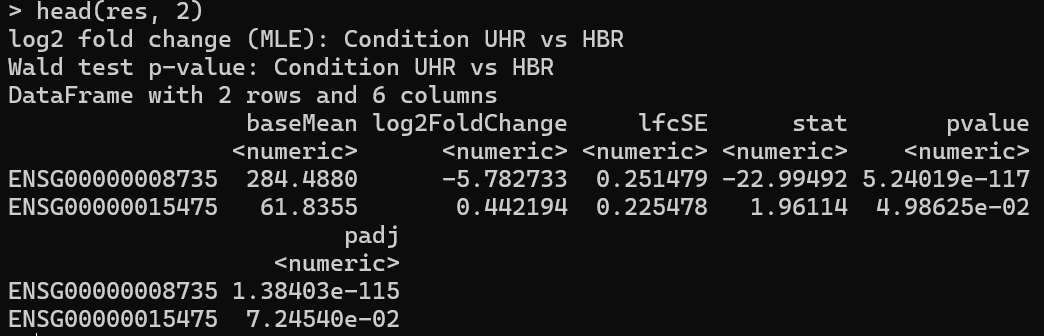

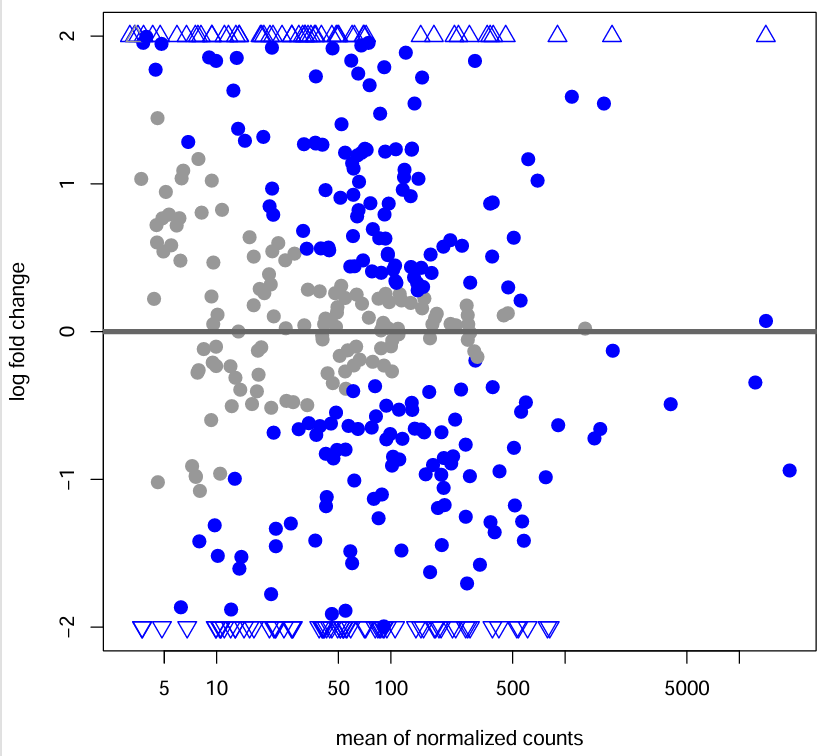

# MA-plot after LFC shrinkage
When we ran DESeq2 we obtained two results, one with and one without log-fold change shrinkage. **When you have genes with low hits you can get some very large fold changes. For example 1 hit on a gene vs 6 hits on a gene is a 6x fold change. This high level of variance though is probably quantifying noise instead of real biology.** Running plotMA on our results where we applied an algorithm for log fold change shrinkage we can see that this “effect” is somewhat controlled for. 

I do want to note that while shrinking LFC is part of a typical DE workflow **there are cases where you would not want to perform this, namely when there is already low variation amongst samples (i.e. from technical replicates)** as most shrinkage algorithms rely on some variability to build a prior distribution.

In [ ]:
# ma plot
pdf("maplot_postShrink.pdf")
plotMA(resLFC, ylim = c(-2, 2), cex=1.5)
dev.off()

The effect is very subtle here due to the focused nature of our dataset (chr22 genes only), but if you toggle between the two plots and **look in the upper left and bottom left corners** you can see some fold change values are moving closer to 0.

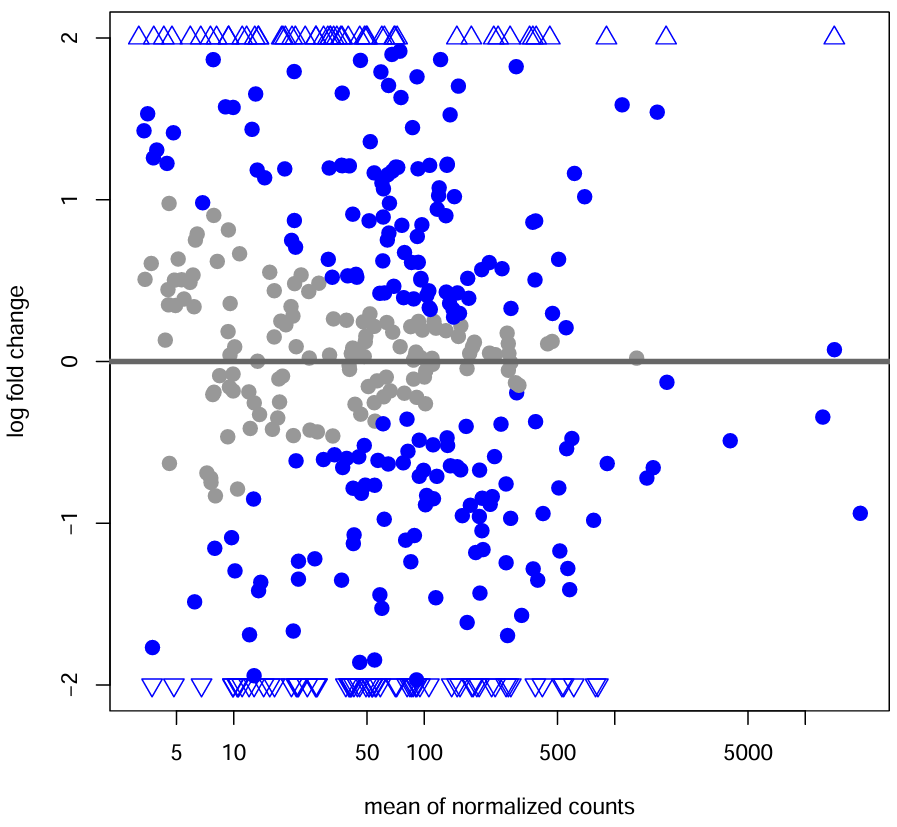

## [Optional] To overlay gene labels selectively on your DESeq2 MA plot, you can follow these steps.
1. Label specific genes of interest (like SEPT3 and PRAME),
2. Label the top 2 high-expression significant DEGs, and
3. Label genes whose log2FC is "shrunk" toward 0 after shrinkage, especially from low-count regions (left side).

Note that: We can map gene IDs without Bioconductor (e.g., using biomaRt or AnnotationHub), especially if you’re working in a restricted EC2 environment.

In [ ]:
# Because ggrepel and org.Hs.eg.db haven't been installed yet
install.packages("ggrepel", repos = "http://cran.us.r-project.org")
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("org.Hs.eg.db")

#library(DESeq2)
library(ggplot2)
library(ggrepel)  # for nice non-overlapping text labels
library(AnnotationDbi)
library(org.Hs.eg.db)

# Add gene symbols to your results
res$symbol <- mapIds(org.Hs.eg.db,
                     keys = rownames(res),
                     column = "SYMBOL",
                     keytype = "ENSEMBL",
                     multiVals = "first")

# Add gene symbols again for res_shrink
resLFC$symbol <- mapIds(org.Hs.eg.db,
                            keys = rownames(resLFC),
                            column = "SYMBOL",
                            keytype = "ENSEMBL",
                            multiVals = "first")

# Genes to always label
label_genes <- c("ENSG00000100167", "ENSG00000185686")  # SEPT3 and PRAME

# Top 2 significant DEGs with high baseMean (expression)
top2_expr <- rownames(resLFC[order(resLFC$padj, -resLFC$baseMean), ])[1:2]

# Genes on far left with large pre-shrinkage FC, now closer to 0
left_genes <- rownames(resLFC)[
  which(res$baseMean < 50 & 
        abs(res$log2FoldChange) > 1.8 & 
        abs(resLFC$log2FoldChange) < 1.8)
]
left_genes <- head(left_genes, 4)

# Combine all genes to label
genes_to_label <- unique(c(label_genes, top2_expr, left_genes))

# Create a data.frame for plotting
res_df <- as.data.frame(resLFC)
res_df$gene <- rownames(res_df)
res_df$label <- ifelse(res_df$gene %in% genes_to_label, res_df$symbol, NA)
res_df$significant <- ifelse(res_df$padj < 0.1, "yes", "no")

# Plot using ggplot2
pdf("maplot_postShrink_withGeneSymbol.pdf")
ggplot(res_df, aes(x = baseMean, y = log2FoldChange, color = significant)) +
  geom_point(size = 1.5) +
  scale_x_log10() +
  geom_hline(yintercept = 0, color = "black") +
  geom_text_repel(
    aes(label = label),
    size = 3,
    max.overlaps = 1000,
    segment.color = "black",     # Line color
    segment.size = 0.3,          # Line thickness
    min.segment.length = 0       # Ensure line is always drawn
  ) +
  scale_color_manual(values = c("no" = "grey", "yes" = "blue")) +
  theme_minimal() +
  labs(x = "Mean of normalized counts", y = "Log2 fold change (shrinked)",
       title = "MA Plot with Selected Gene Labels after log2FC shrinkage")
dev.off()

### Outputs

#### 1. Added symbol column to res
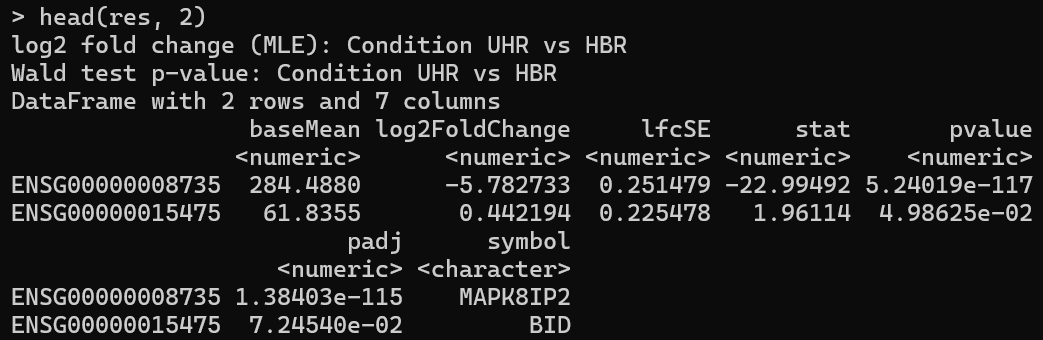

#### 2. Added symbol column to resLFC
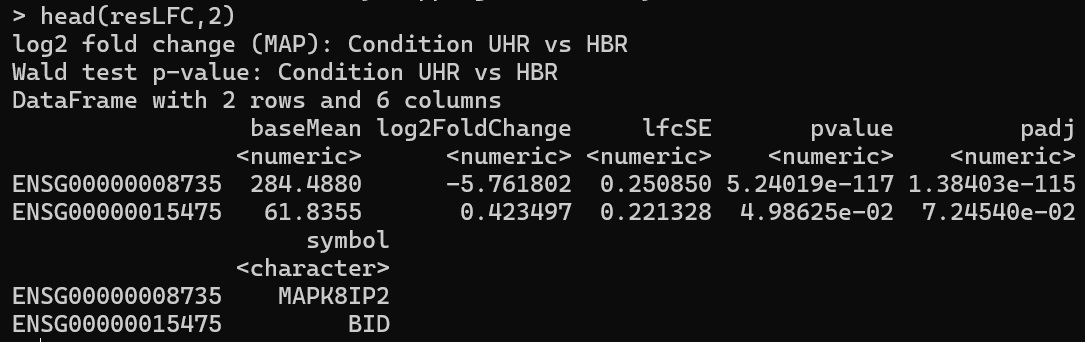

#### 3. top2_expr
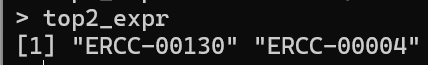

#### 4. left_genes
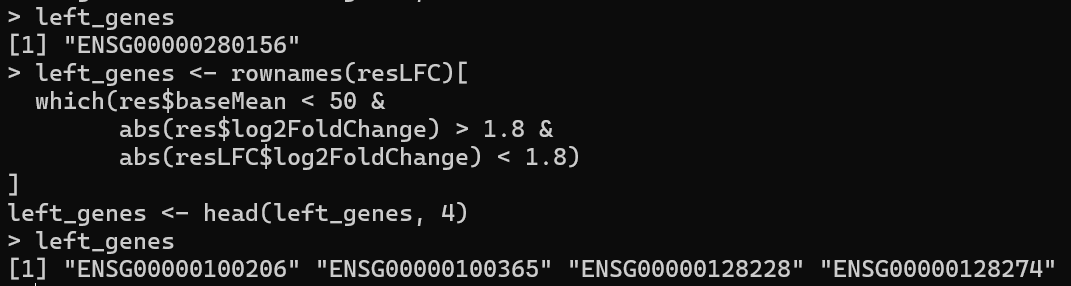

#### 5. MA Plot with Selected Gene Labels after log2FC shrinkage
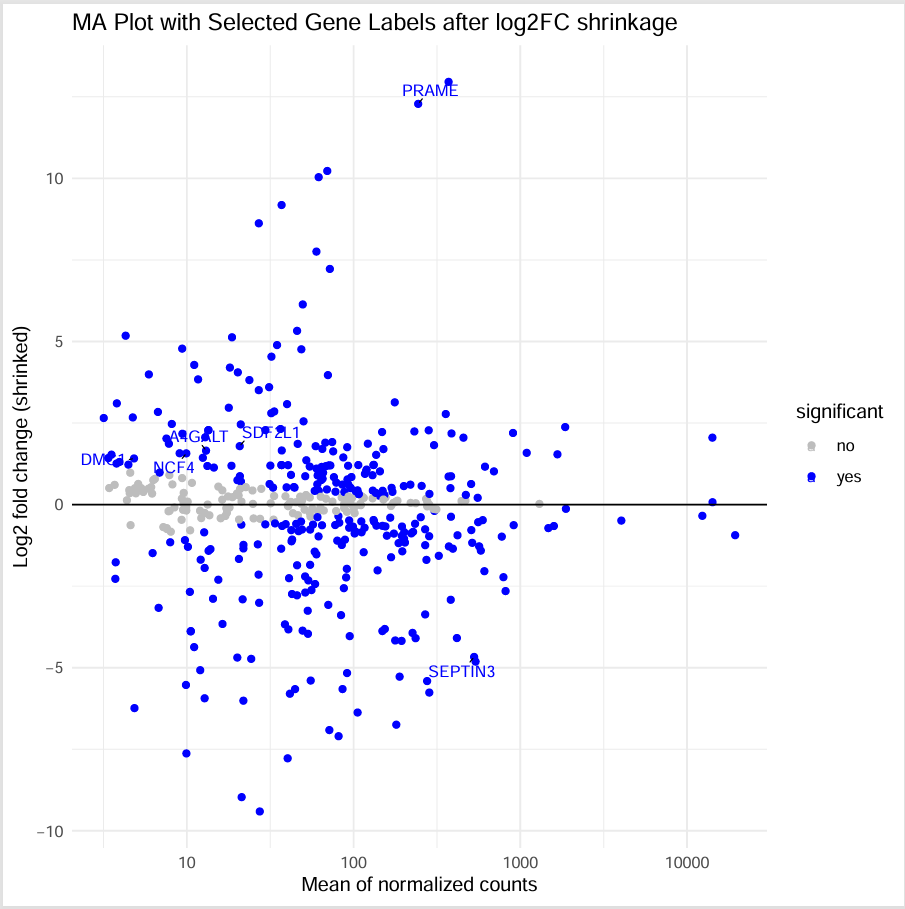

# Viewing individual gene counts between two conditions
Often it may be useful to view the normalized counts for a gene amongst our samples. DESeq2 provides a built in function for that which works off of the dds object. Here we view **SEPT3 which we can see in our DE output is significantly higher in the HBR cohort** and **PRAME which is significantly higher in the UHR cohort**. This is useful as we can see the per-sample distribution of our corrected counts, we can immediately determine if there are any outliers within each group and investigate further if need be.

In [ ]:
# hint! you defined intgroup when creating the dds object, you can view the name by printing the dds objct in your R session
# dds

pdf("normalized_count_examples.pdf")

# view SEPT3 normalized counts
plotCounts(dds, gene = "ENSG00000100167", intgroup = "Condition", main = "SEPT3")

# view PRAME normalized counts
plotCounts(dds, gene = "ENSG00000185686", intgroup = "Condition", main = "PRAME")

dev.off()

# Viewing pairwise sample clustering
It may often be useful to view inter-sample relatedness. In other words, how similar or disimilar samples are to one another overall. While not part of the DESeq2 package, there is a convenient library that can easily construct a hierarchically clustered heatmap from our DESeq2 data. 

It should be noted that when **doing a distance calculation using “raw count” data is not ideal, the count data should be transformed using vst() or rlog() which can be performed directly on the dds object.** The reason for this is described in detail in the DESeq2 manuscript, suffice it to say that transforming gene variance to be more homoskedastic will make inferences of sample relatedness more interpretable.

In [ ]:
# note that we use rlog because we don't have a large number of genes, for a typical DE experiment with 1000's of genes use the vst() function
rld <- rlog(dds, blind = FALSE)

# view the structure of this object ("regularized" log2 transformed, see ?rlog for details)
rld
## class: DESeqTransform
## dim: 449 6
## rownames(449): ENSG00000008735 ENSG00000015475 ... ERCC-00170 ERCC-00171
## rowData names(23): baseMean baseVar ... maxCooks rlogIntercept
## colnames(6): UHR_Rep1 UHR_Rep2 ... HBR_Rep2 HBR_Rep3
## colData names(2): Condition sizeFactor


# compute sample distances (the dist function uses the euclidean distance metric by default)
# in this command we will pull the rlog transformed data ("regularized" log2 transformed, see ?rlog for details) using "assay"
# then we transpose that data using t()
# then we calculate distance values using dist() 
# the distance is calculated for each vector of sample gene values, in a pairwise fashion comparing all samples

# view the first few lines of raw data
head(assay(dds))

# see the rlog transformed data
head(assay(rld))

# see the impact of transposing the matrix
t(assay(rld))[1:6, 1:5]

# see the distance values
dist(t(assay(rld)))

# put it all together and store the result
sampleDists <- dist(t(assay(rld)))

# convert the distance result to a matrix
sampleDistMatrix <- as.matrix(sampleDists)

# view the distance numbers directly in the pairwise distance matrix
head(sampleDistMatrix)

pdf("distance_sample_heatmap.pdf", width = 8, height = 8)

# construct clustered heatmap, important to use the computed sample distances for clustering
pheatmap(sampleDistMatrix, clustering_distance_rows = sampleDists, clustering_distance_cols = sampleDists)

dev.off()

## Outputs

#### 1. head(assay(dds)) and head(assay(rld))
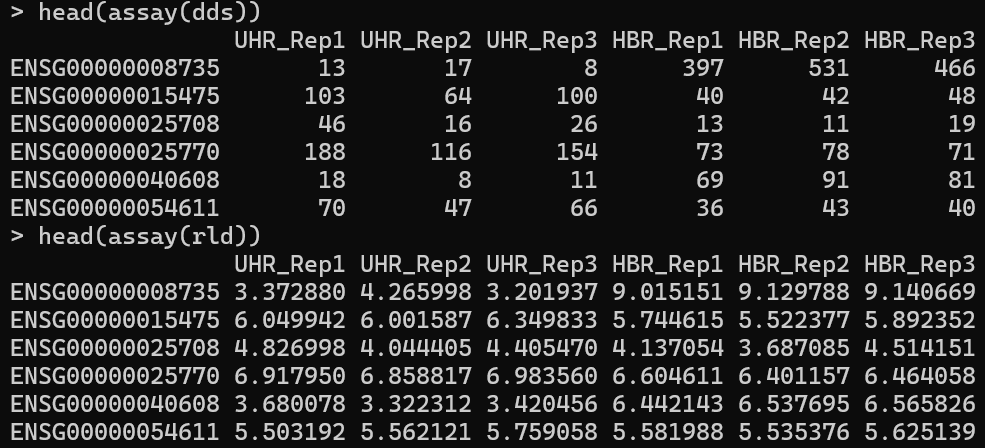

#### 2. t(assay(rld))[1:6, 1:5]
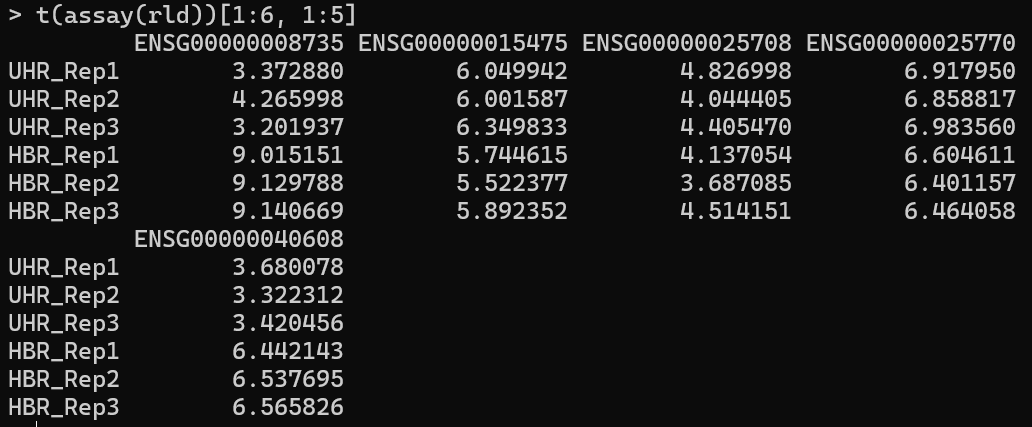

#### 3. dist(t(assay(rld)))
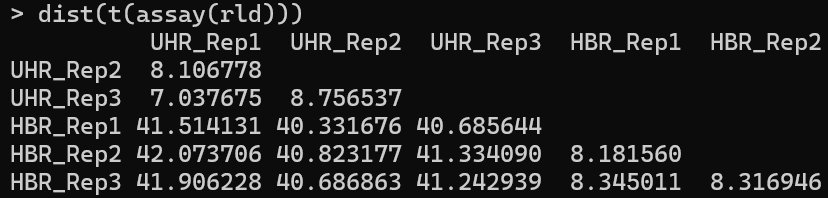

#### 4. head(sampleDistMatrix)
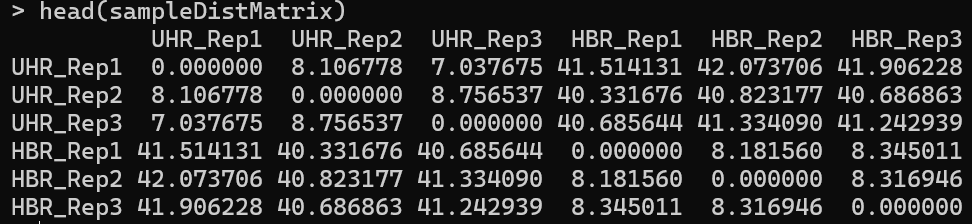

#### 5. clustered heatmap
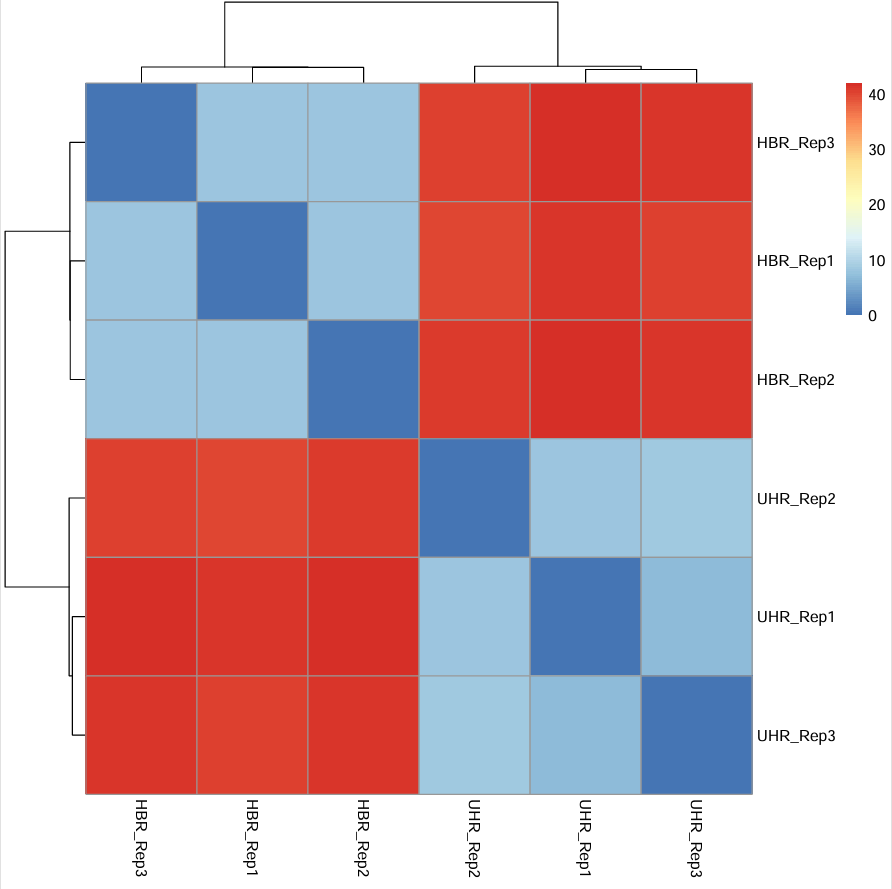


## Instead of a distance metric we could also use a similarity metric such as a Peason correlation
There are many correlation and distance options:

- Correlation: “pearson”, “kendall”, “spearman” 
- Distance: “euclidean”, “maximum”, “manhattan”, “canberra”, “binary” or “minkowski”

In [ ]:
sampleCorrs = cor(assay(rld), method = "pearson")
sampleCorrMatrix = as.matrix(sampleCorrs)
head(sampleCorrMatrix)

pdf("similarity_sample_heatmap.pdf", width = 8, height = 8)
pheatmap(sampleCorrMatrix)
dev.off()

## Outputs

#### 1. head(sampleCorrMatrix)
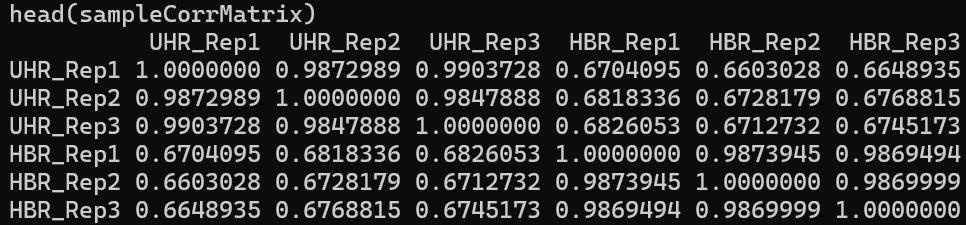

#### 2. Pearson correlation heatmap
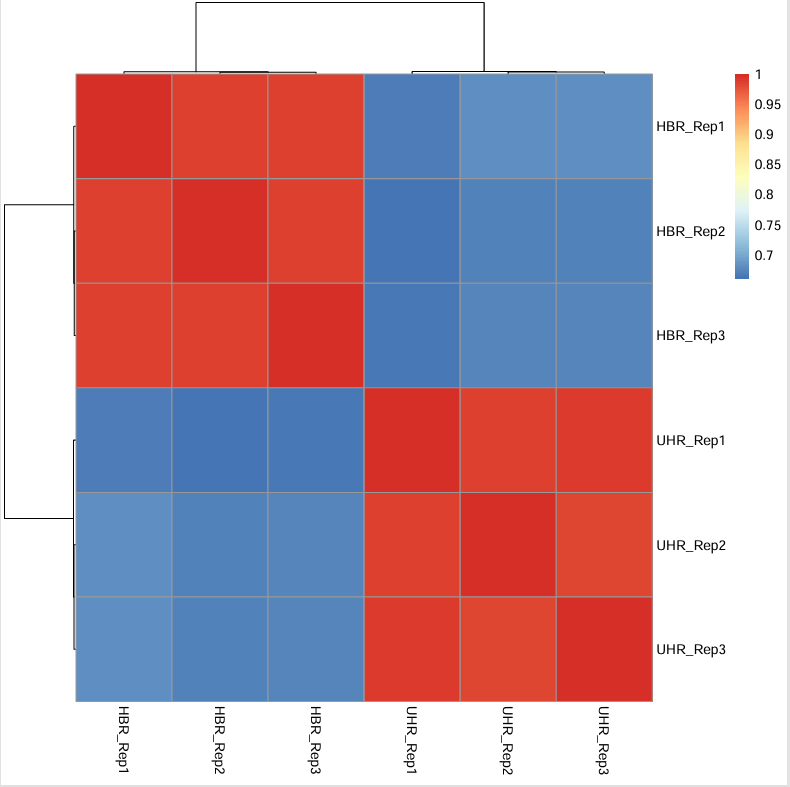

## Instead of boiling all the gene count data for each sample down to a distance metric you can get a similar sense of the pattern by just visualizing all the genes at once

In [ ]:
pdf("all_gene_heatmap.pdf", width = 10, height = 10)
pheatmap(mat = t(assay(rld)), show_colnames = FALSE) # because there are so many gene we choose not to display them
dev.off()

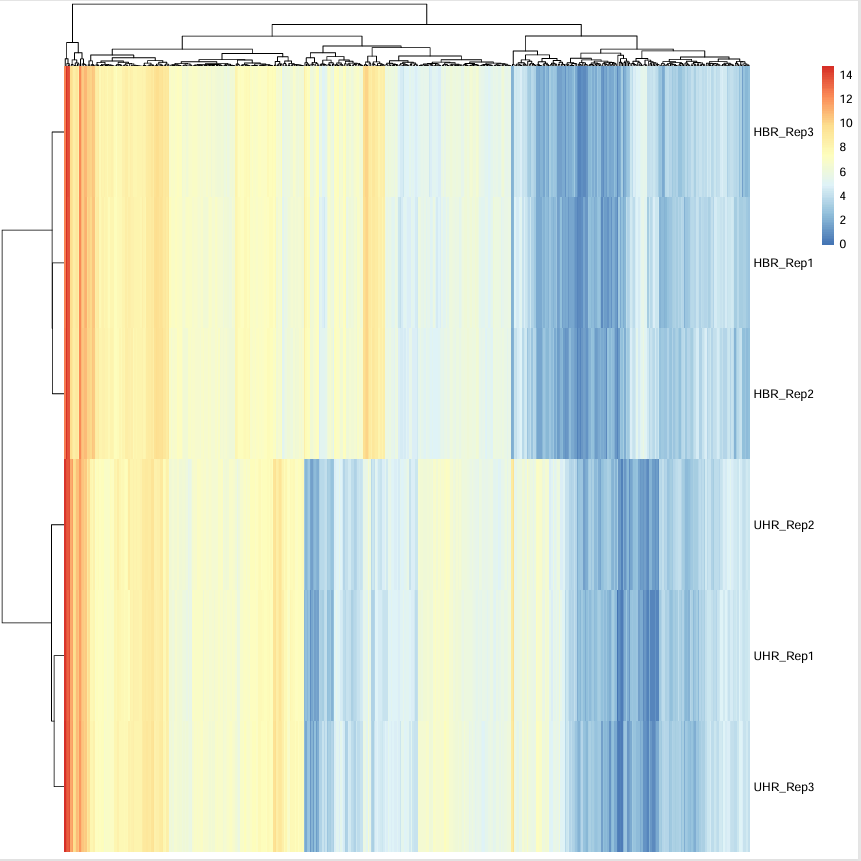